CSCI-P556: Applied Machine Learning
Fall 2018
Assignment #2
---



## Problem 1 (50 points)

In this problem you will be working with Bank Marketing Dataset. We encourage your to look at the description and make yourself comfortable with it: https://archive.ics.uci.edu/ml/datasets/bank+marketing

Two pairs of training and validation sets have been drawn from this dataset for you to work with, namely: 
 -  `train_1.csv` and `valid_1.csv`
 -  `train_2.csv`and `valid_2.csv`
 
Finally, we have also provided a `test.csv` which is common for both settings.

### Task 0: (3 points)

What is the difference between the two sets of train/validation sets? Write your answer here:

### Ans: 
Although at first glance the two sets of train/validation sets looks identical on close inspection it turns out that for set 1 the distribution of 0's and 1's (i.e. dependent/target variable) is identical (~50%) whereas for set 2 the distribution of the dependent variable is skewed with an event rate of around 13%


### Task 1 (Data Preprocessing) (12 points)

Before you can train a machine learning model using this dataset, you will have to run a number of preprocessing steps to transform the data into a form which will be acceptable to the model. In this task, you are supposed to carry out the follow steps:

1.  Find all features that have continuous numeric values and normalize them in the same way as you did in Assignment 1. List those features here.
2. Find all categorical features and process them as was discussed in class. List those features and explain what you did.
3. Are there any features which have missing values? (Hint: Missing values aren't always nicely represented and can be misleading sometimes). Find those features and explain how you will handle them.



Write your text-based answers here.


1.   The numerical features are - *age, balance, duration, pdays, previous, campaign and day*
2.  The categorical features are - *job, marital, education, default, housing, loan, contact, month, poutcome*. \
Out of these some are binary categorical variables whereas some have more than 2 factors/levels. For the categorical variables that are binary (e.g. *default, housing, loan*) we can go ahead and encode them as \
'no' - 0 and 'yes' - 1. \
On the other hand, for the categorical variables with more than 2 levels ( e.g. *job, marital, education, contact, month, poutcome*) we can create dummy variables
3.   There are a few categorical variables which have 'unknown' as one of the levels. We will not treat these as missing values but as seperate category. On the other hand for the numeric feature 'pdays' we see 74% of the values are -1, we will have to perform missing value treatment (replace with median) for this variable



In [198]:
import pandas as pd
train_1 = pd.read_csv('./train_1.csv')
len(train_1[train_1['pdays']==-1])/len(train_1)

0.7475254838233122

**Preprocessing**

In [203]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

def calculate_stats(X, numeric_cols):
    
    x_u = np.mean(X[numeric_cols].to_numpy(), axis = 0)
    
    x_norm = np.linalg.norm(X[numeric_cols], axis = 0)
            
    return x_u, x_norm

def treat_binary_categorical(X, categorical_cols):
    for col in categorical_cols:
        X[col] = X[col].apply(lambda x : 1 if x == 'yes' else 0)
    return X

def treat_numeric(X, numeric_cols, x_u, x_norm):
    n_samples, n_features = X[numeric_cols].shape
    X_u = np.repeat(x_u,n_samples).reshape(n_features,n_samples).T
    X_norm = np.repeat(x_norm,n_samples).reshape(n_features,n_samples).T
    X[numeric_cols] = (X[numeric_cols]-X_u)/X_norm
    return X

def treat_multi_categorical(X, categorical_cols):
    X = pd.get_dummies(X, 
                columns = categorical_cols ,
                drop_first = True)
    return X
  
def impute_w_mean(X, col, val, median = None):
    if median == None:
        median  = np.median(X[col][X[col] != val])
    X[col] = [median if x == val else x for x in X[col]]
    return X, median

def preprocessing(X, x_u = np.array([None]), x_norm = np.array([None]), m=None):
    numeric_cols = ['age', 'balance', 'duration', 'pdays', 'previous', 'day', 'campaign']
    X, pdays_median = impute_w_mean(X, 'pdays', -1, m)
    
    if x_u.all() == None:
        x_u, x_norm = calculate_stats(X, numeric_cols)
    
    X = treat_numeric(X, numeric_cols, x_u, x_norm)
    
    categorical_cols = ['default','housing','loan','y']
    X = treat_binary_categorical(X, categorical_cols)
    
    other_categorical_cols = ['job', 'marital', 'education', 
                    'contact', 'month', 'poutcome']
    X = treat_multi_categorical(X, other_categorical_cols)
    
    x , y = X.drop('y', axis=1), X['y']
    return x, y, x_u, x_norm, pdays_median

def get_predictions(y_prob, threshold = 0.5):
    y_pred = [1 if x >= threshold else 0 for x in y_prob[:, 1]]
    return y_pred

In [204]:
# PROBLEM 1, TASK 1 CODE GOES HERE
train_1 = pd.read_csv('./train_1.csv')
valid_1 = pd.read_csv('./valid_1.csv')
train_2 = pd.read_csv('./train_2.csv')
valid_2 = pd.read_csv('./valid_2.csv')
test = pd.read_csv('./test.csv')
# print(train_1.columns)

train_1_x , train_1_y, train_1_x_u, train_1_x_norm, train_1_pdays_median = preprocessing(train_1)
valid_1_x, valid_1_y, _, _, _ = preprocessing(valid_1, train_1_x_u, train_1_x_norm, train_1_pdays_median)
test_1_x, test_1_y, _, _, _ = preprocessing(test, train_1_x_u, train_1_x_norm, train_1_pdays_median)

train_2_x , train_2_y, train_2_x_u, train_2_x_norm, train_2_pdays_median = preprocessing(train_2)
valid_2_x, valid_2_y, _, _, _ = preprocessing(valid_2, train_2_x_u, train_2_x_norm, train_2_pdays_median)
test_2_x, test_2_y, _, _, _ = preprocessing(test, train_2_x_u, train_2_x_norm, train_2_pdays_median)


print(train_1.shape, train_1_x.shape, train_1_y.shape)
print(valid_1.shape, valid_1_x.shape, valid_1_y.shape)
print(test.shape, test_1_x.shape, test_1_y.shape)
print(train_2.shape, train_2_x.shape, train_2_y.shape)
print(valid_2.shape, valid_2_x.shape, valid_2_y.shape)
print(test.shape, test_2_x.shape, test_2_y.shape)

(6769, 17) (6769, 42) (6769,)
(1693, 17) (1693, 42) (1693,)
(9043, 17) (9043, 42) (9043,)
(28934, 17) (28934, 42) (28934,)
(7234, 17) (7234, 42) (7234,)
(9043, 17) (9043, 42) (9043,)


### Task 2 (Model $\mathcal{A}$) (10 points)

Train a logistic regression model with $L_2$ regularization on `train_1.csv` after applying the necessary preprocessing steps of Task 1. Use the validation set `valid_1.csv` to choose the best regularization coefficient $\lambda$. Plot a curve with regularization coefficient in the X axis and the validation accuracy on the Y axis.

Distribution of dependant var
1    3385
0    3384
Name: y, dtype: int64
Train Accuracy:  0.797459004284237
Validation Accuracy:  0.7838157117542823
Test Accuracy:  0.8347893398208559


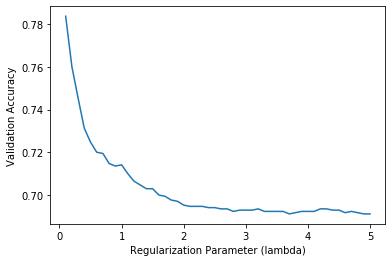

In [205]:
# PROBLEM 1, TASK 2 CODE GOES HERE

## Look at distribution of 1's and 0's for imbalance ##
print('Distribution of dependant var')
print(train_1_y.value_counts())

## Hyperparameter Tuning ##
accuracy = []
reg_param = []
for c in range(1, 51, 1):
    reg_param.append(c/10)
    lr = LogisticRegression(penalty = 'l2', 
                            solver = 'lbfgs',
                            C = 10/c, 
                            max_iter = 300)
    lr.fit(train_1_x, train_1_y)
    valid_1_prob_predictions = lr.predict_proba(valid_1_x)
    y_pred = get_predictions(valid_1_prob_predictions)
    accuracy.append(accuracy_score(valid_1_y, y_pred))


plt.plot(reg_param, accuracy)

plt.ylabel('Validation Accuracy')
plt.xlabel('Regularization Parameter (lambda)')

## Train/Validation/Test Accuracy

best_lambda = reg_param[np.argmax(accuracy)]
lr = LogisticRegression(penalty = 'l2', 
                            solver = 'lbfgs',
                            C = 1/best_lambda, 
                            max_iter = 300)
lr.fit(train_1_x, train_1_y)

train_1_prob_predictions = lr.predict_proba(train_1_x)
valid_1_prob_predictions = lr.predict_proba(valid_1_x)
test_1_prob_predictions = lr.predict_proba(test_1_x)

print("Train Accuracy: ",accuracy_score(train_1_y, get_predictions(train_1_prob_predictions)))
print("Validation Accuracy: ",accuracy_score(valid_1_y, get_predictions(valid_1_prob_predictions)))
print("Test Accuracy: ",accuracy_score(test_1_y, get_predictions(test_1_prob_predictions)))


# plt.show()
# df.plot()

### Task 3 (Model $\mathcal{B}$) (5 points)
Train a logistic regression model with $L_2$ regularization on `train_2.csv` after applying the necessary preprocessing steps of Task 1. Use the validation set `valid_2.csv` to choose the best regularization coefficient $\lambda$. Plot a curve with regularization coefficient in the X axis and the validation accuracy on the Y axis.

Distribution of dependant var
0    25549
1     3385
Name: y, dtype: int64
Train Accuracy:  0.895866454689984
Validation Accuracy:  0.8959082112247719
Test Accuracy:  0.9786575251575804


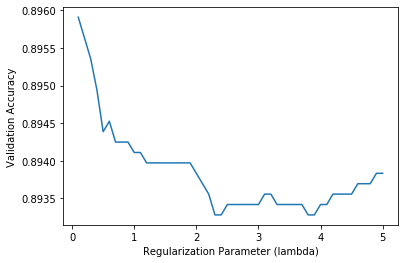

In [206]:
# PROBLEM 1, TASK 3 CODE GOES HERE

## Look at distribution of 1's and 0's for imbalance ##
print('Distribution of dependant var')
print(train_2_y.value_counts())

## Hyperparameter Tuning ##
accuracy = []
reg_param = []
for c in range(1, 51, 1):
    reg_param.append(c/10)
    lr = LogisticRegression(penalty = 'l2', 
                            solver = 'lbfgs',
                            C = 10/c, 
                            max_iter = 300)
    lr.fit(train_2_x, train_2_y)
    valid_2_prob_predictions = lr.predict_proba(valid_2_x)
    y_pred = get_predictions(valid_2_prob_predictions)
    accuracy.append(accuracy_score(valid_2_y, y_pred))


plt.plot(reg_param, accuracy)

plt.ylabel('Validation Accuracy')
plt.xlabel('Regularization Parameter (lambda)')

## Train/Validation/Test Accuracy

best_lambda = reg_param[np.argmax(accuracy)]
lr = LogisticRegression(penalty = 'l2', 
                            solver = 'lbfgs',
                            C = 1/best_lambda, 
                            max_iter = 300)
lr.fit(train_2_x, train_2_y)

train_2_prob_predictions = lr.predict_proba(train_2_x)
valid_2_prob_predictions = lr.predict_proba(valid_2_x)
test_2_prob_predictions = lr.predict_proba(test_2_x)

print("Train Accuracy: ",accuracy_score(train_2_y, get_predictions(train_2_prob_predictions)))
print("Validation Accuracy: ",accuracy_score(valid_2_y, get_predictions(valid_2_prob_predictions)))
print("Test Accuracy: ",accuracy_score(test_2_y, get_predictions(test_2_prob_predictions)))



### Task 4 (Model $\mathcal{C}$) (10 points)

As you have seen in class, due to the specific (and smart) choice of the loss function, a logistic regression classifier happens to predict the posterioir probability $p(y|\mathbf{x})$ for any given sample. It then classifies the samples with $p(y|\mathbf{x}) > 0.5$ as belonging to class $1$ and the rest as belonging to class $0$. Instead, for a fixed threshold of $0.5$, let us consider a dynamic threshold of $\theta$ which can be chosen after a model has been trained.

$$
\ y=
\begin{cases}
1 \text{ if } p(y|\mathbf{x}) \geq \theta \\
\\
0 \text{ if } p(y|\mathbf{x}) < \theta \\
\end{cases}
$$

for $0 \leq \theta \leq 1$.

Train a logistic regression model with $L_2$ regularization on `train_2.csv` after applying the necessary preprocessing steps of Task 1. Use the validation set `valid_2.csv` to choose the best combination of regularization coefficient $\lambda$ and the threshold $\theta$. The best coefficients has to be selected by you after trying out at least five, non-consecutive values. Visualize all these runs.

**Hint**: Look at the documentation of Logistic Regression in sci-kit learn to come up with a plan to implement this.

Text(0.5, 0, 'Regularization Parameter (lambda)')

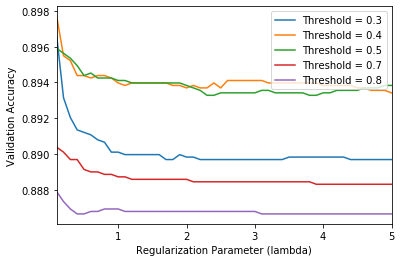

In [207]:
# PROBLEM 1, TASK 4 CODE GOES HERE

def get_accuracies(th):
    accuracy = {}
    for c in range(1, 51, 1):
        reg_param = c/10
        lr = LogisticRegression(penalty = 'l2', 
                                solver = 'lbfgs',
                                C = 10/c, 
                                max_iter = 300)
        lr.fit(train_2_x, train_2_y)
        valid_2_prob_predictions = lr.predict_proba(valid_2_x)
        y_pred = get_predictions(valid_2_prob_predictions, threshold = th)
        
        accuracy[reg_param] = accuracy_score(valid_2_y, y_pred)
    return accuracy

th_1, th_2, th_3, th_4, th_5 = 0.3, 0.4, 0.5, 0.7, 0.8

data = {'Threshold = ' + str(th_1): get_accuracies(th_1),
        'Threshold = ' + str(th_2): get_accuracies(th_2),
        'Threshold = ' + str(th_3): get_accuracies(th_3),
        'Threshold = ' + str(th_4): get_accuracies(th_4),  
        'Threshold = ' + str(th_5): get_accuracies(th_5)}
    
    
df = pd.DataFrame(data)

df.plot(kind='line')

plt.ylabel('Validation Accuracy')
plt.xlabel('Regularization Parameter (lambda)')



In [208]:
# Visually inspect the validation accuracy for different combo 
# of threshold and lambda to select the best hyperparameters
df

,Threshold = 0.3,Threshold = 0.4,Threshold = 0.5,Threshold = 0.7,Threshold = 0.8
0.1,0.896599,0.897705,0.895908,0.890379,0.887891
0.2,0.893143,0.895494,0.895632,0.890102,0.887338
0.3,0.892038,0.895217,0.895355,0.889688,0.886923
0.4,0.891346,0.894388,0.894941,0.889688,0.886646
0.5,0.891208,0.894388,0.894388,0.889135,0.886646
0.6,0.891070,0.894249,0.894526,0.888996,0.886785
0.7,0.890793,0.894388,0.894249,0.888996,0.886785
0.8,0.890655,0.894388,0.894249,0.888858,0.886923
0.9,0.890102,0.894249,0.894249,0.888858,0.886923
1.0,0.890102,0.893973,0.894111,0.888720,0.886923


In [209]:
## Train/Validation/Test Accuracy

best_lambda = 0.1
th = 0.4
lr = LogisticRegression(penalty = 'l2', 
                            solver = 'lbfgs',
                            C = 1/best_lambda, 
                            max_iter = 300)
lr.fit(train_2_x, train_2_y)

train_2_prob_predictions = lr.predict_proba(train_2_x)
valid_2_prob_predictions = lr.predict_proba(valid_2_x)
test_2_prob_predictions = lr.predict_proba(test_2_x)

print("Train Accuracy: ",accuracy_score(train_2_y, get_predictions(train_2_prob_predictions, threshold = th)))
print("Validation Accuracy: ",accuracy_score(valid_2_y, get_predictions(valid_2_prob_predictions, threshold = th)))
print("Test Accuracy: ",accuracy_score(test_2_y, get_predictions(test_2_prob_predictions, threshold = th)))



Train Accuracy:  0.8957973318587129
Validation Accuracy:  0.8977052806192978
Test Accuracy:  0.9635076855025987


### Task 5 (Report and Conclusion) (10 points)

1.  Give a detailed report on the performance (that is, accuracy) of Models $\mathcal{A}$, $\mathcal{B}$ and $\mathcal{C}$ on the respective training sets, the validation sets and finally the test. Explain any intuition you might have on what might be happening in each of the cases. Please avoid writing unnecessary details which are not pertinent.

2.  Do you think accuracy, the metric which you have used to find the best hyperparameter in all the above tasks, a good metric in this scenario? Explain your choice.

Ans 1.- For Model $\mathcal{B}$, and $\mathcal{C}$ since the distribution of 1-0s is highly imbalanced we get higher values of accuracy (for training, validation and test data) wrt Model $\mathcal{A}$. This is because the Model $\mathcal{B}$, and $\mathcal{C}$ are predicting the 0s more accurately than the 1s.

Model $\mathcal{A}$ \
Train Accuracy:  0.797459004284237 \
Validation Accuracy:  0.7838157117542823 \
Test Accuracy:  0.8347893398208559

Model $\mathcal{B}$ \
Train Accuracy:  0.8960392617681621 \
Validation Accuracy:  0.8961846834393143 \
Test Accuracy:  0.9789892734711931

Model $\mathcal{C}$ \
Train Accuracy:  0.89621206884634 \
Validation Accuracy:  0.8981199889411114 \
Test Accuracy:  0.9652770098418666

Ans 2.- For Model $\mathcal{A}$, since set 1 has equal distribution of the target variable we can rely on accuracy to find the best hyperparameter. But for Model $\mathcal{B}$ and  $\mathcal{C}$ since the distribution of target variable is highly imbalanced in set 2, we should look at other metrics like f1-score , weighted-accuracy etc.

## Problem 2 (50 points)

Consider a regression problem in which the input variable $x$ has only one feature and the target variable $y$ is generated from the input variable $x$ by a polynomial $f(x)$. The function $f$ is such that $$f(x) = \sum_{i=0}^d w_ix^i$$ Please note that a given polynomial function can be completely described by the vector of coefficients $\mathbf{w}$.

### Task 1 (5 points)

Write a function in python which can take the degree of polynomial function as input. The code to generate vector coefficeints $\mathbf{w}$ using this input is already provided. Plot the resulting function for $x \in (-low, high)$. The function should be plot 

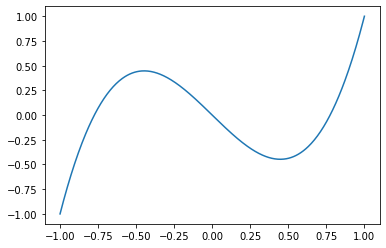

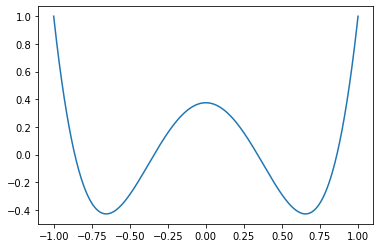

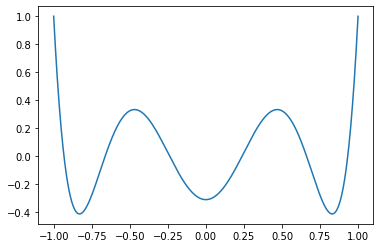

In [210]:
import numpy as np
from scipy.special import legendre

def get_coefficients(degree):
    """
    The coefficients returned are in the order w_0, w_1, ... , w_{degree}
    """
    return legendre(degree).coefficients[::-1]

def visualize_function(degree, low, high):
    w = get_coefficients(degree)
    x = np.linspace(low, high, 500)
    X = np.ones((1,len(x)))
    for deg in range(1, degree+1 ):
        X = np.vstack((X, x**deg))    
    y = np.dot(w,X)
    plt.plot(X[1][:],y)
    plt.show()

## TEST CASES (The following lines should plot a function)
visualize_function(3, -1, 1)
visualize_function(4, -1, 1)
visualize_function(6, -1, 1)

## Task 2 (5 points)

Write a function in python that randomly generates a dataset (training data + test data). The function should take the degree of target polynomial as input along with the number of points that should be generated for both the training and the test sets. The polynomial will be represented by the vector of coefficients. The code to calculate these coefficients has been provided. The function should also add random normal noise to the target -- i.e. the noise should be drawn from a normal distribution with mean $\mu=0$ and standard deviation = $\sigma^2$. Thus: 
$$y=\sum_{i=0}^d w_ix^i + \mathcal{N}(0, \sigma^2)$$



In [211]:
from sklearn.model_selection import train_test_split
def generate_dataset(degree, n_train, n_test, sigma):
    """
    - n_train - Number of training samples
    - n_test - Number of test samples
    - X_train is an array of size (n_train $\times$ 1)
    - y_train is an array of size (n_train $\times$ 1)
    - X_test is an array of size (n_test $\times$ 1)
    - y_test is an array of size (n_test $\times$ 1)
    """
    w = get_coefficients(degree)
    X = np.ones((1, n_train+n_test))
    x = np.linspace(-1,1,n_train+n_test)
    for deg in range(1, degree+1 ):
        X = np.vstack((X, x**deg))    
    noise = np.random.normal(0, sigma, n_train+n_test)
    y = np.dot(w,X) + noise
    
    all_X = X[1][:]
    
    X_train, X_test, y_train, y_test = train_test_split(all_X, y, 
                                                        test_size=n_test/(n_train+n_test), 
                                                        random_state=42)
    
     
    
    return X_train.reshape(n_train,1), X_test.reshape(n_test,1), y_train.reshape(n_train,1), y_test.reshape(n_test,1)


### Task 3 (20 points)

1.   Use the function written in Task 2 to generate a dataset of degree $10$, with $20$ samples each in the training and test sets. The standard deviation of the noise should be $0.2$.
2.   Plot the generated points of the train set over the function. Make use the function you wrote in Task 1 to do so. The resultant plot should not only contain the function in blue color but also the generated points in the train set in red color.
3.   Fit two linear regressions models: $\mathcal{A}$ and $\mathcal{B}$ on the given training data. Model $\mathcal{A}$ should be quadratic and Model $\mathcal{B}$ should be of degree $10$. How would you create such models?
4. Calculate the training error and testing error on both these models and report them nicely in a table.
5. Explain the results:
 - Are the results as expected or surprising? Explain your stance.
 - Give a detailed explanation of why this happens.
 
 **Hint**: You are free (in fact encouraged) to design new experiments under the same paradigm to understand what is happening. You can buttress your explanation with any plots which you might generate from such new experiments.

 
Note: _There is no preference over the size of the answer but please note that you shouldn't write anything that is not pertinent. While being terse, your answer should clearly convey the intuition. Also, use logical number code/text cells---i.e. every subquestion in a given task which can be considered a logical unit should be present in one cell. Do not make one cell unnecessarily long by putting multiple answers in it or split a given answer over multiple cells. Use your best judgement.

(20, 1) (20, 1) (20, 1) (20, 1)


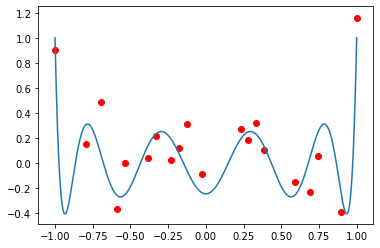

In [194]:
x_t, x_te, y_t, y_te = generate_dataset(10, 20, 20, 0.2)
print(x_t.shape, x_te.shape, y_t.shape, y_te.shape)
plt.scatter(x_te, y_te, c = 'red')
visualize_function(10, -1, 1)


In [195]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Degree 2 #
poly = PolynomialFeatures(2)
x_t_poly = poly.fit_transform(x_t)
x_te_poly = poly.fit_transform(x_te)
lr = LinearRegression()
model = lr.fit(x_t_poly, y_t)
y_te_pred = model.predict(x_te_poly)
y_t_pred = model.predict(x_t_poly)
print('**** Model A ****')
print('Test error', mean_squared_error(y_te, y_te_pred))
print('Train error', mean_squared_error(y_t, y_t_pred))

print('\n')
# Degree 10 #
poly = PolynomialFeatures(10)
x_t_poly = poly.fit_transform(x_t)
x_te_poly = poly.fit_transform(x_te)
lr = LinearRegression()
model = lr.fit(x_t_poly, y_t)
y_te_pred = model.predict(x_te_poly)
y_t_pred = model.predict(x_t_poly)

print('**** Model B ****')
print('Test error', mean_squared_error(y_te, y_te_pred))
print('Train error', mean_squared_error(y_t, y_t_pred))

**** Model A ****
Test error 0.2054837941119146
Train error 0.08791431726769194


**** Model B ****
Test error 0.42345336423558333
Train error 0.027476478681310368


To create the polynomial features we have used the amazing PolynomialFeatures class from the preprocessing module of sklearn.

When we try to fit the polynomial of degree 10 (Model $\mathcal{B}$), we can see that the training error has decreased wrt degree 2 (Model $\mathcal{A}$), but the test error has increased. This validates the hypothesis that if we increase the degree of the fit function it tries to overfit to the training data and does not generalize well to unseen data

### Task 4 (20 points)

1.  Use the function written in Task 2 to generate a dataset of degree 45, with 20 samples each in the training and test sets. There should be no noise in the samples.
2.  Repeat steps 2 to 4 from Task 3 for this dataset.
3.  This target doesn't have noise like the previous one. Does this make the result surprising? Explain your stance. Also give a detailed explanation of why this happens.

**Hint**: You are free (in fact encouraged) to design new experiements under the same paradigm to understand what is happening. You can buttress your explanation with any plots which you might generate from such new experiments.

(20, 1) (20, 1) (20, 1) (20, 1)


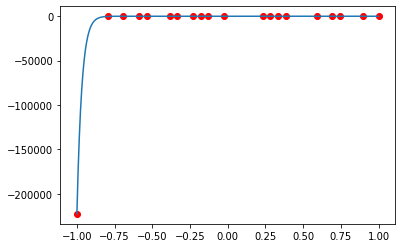

In [196]:
x_t, x_te, y_t, y_te = generate_dataset(45, 20, 20, 0)
print(x_t.shape, x_te.shape, y_t.shape, y_te.shape)
plt.scatter(x_te, y_te, c = 'red')
visualize_function(45, -1, 1)


In [197]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Degree 2 #
poly = PolynomialFeatures(2)
x_t_poly = poly.fit_transform(x_t)
x_te_poly = poly.fit_transform(x_te)
lr = LinearRegression()
model = lr.fit(x_t_poly, y_t)
y_te_pred = model.predict(x_te_poly)
y_t_pred = model.predict(x_t_poly)
print('**** Model A ****')
print('Test error', mean_squared_error(y_te, y_te_pred))
print('Train error', mean_squared_error(y_t, y_t_pred))

print('\n')
# Degree 10 #
poly = PolynomialFeatures(10)
x_t_poly = poly.fit_transform(x_t)
x_te_poly = poly.fit_transform(x_te)
lr = LinearRegression()
model = lr.fit(x_t_poly, y_t)
y_te_pred = model.predict(x_te_poly)
y_t_pred = model.predict(x_t_poly)

print('**** Model B ****')
print('Test error', mean_squared_error(y_te, y_te_pred))
print('Train error', mean_squared_error(y_t, y_t_pred))

**** Model A ****
Test error 2130630659.7025197
Train error 62007890.86260591


**** Model B ****
Test error 446231088.81268865
Train error 489305.72368427087


Since in this case the target does not have noise, as we increase the degree of the fit polynomial it tries to capture the data as closely and accurately as possible. Thus we see both train an test error decrease as we move from Model $\mathcal{A}$ to Model $\mathcal{B}$